Loading data...
Displaying label distribution...
Label distribution: {0: 713, 1: 1287}
Preprocessing data...
Computing class weights...
Building the model...
Training the model...
Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.5979 - loss: 0.7169
Epoch 1: val_loss improved from inf to 1.70093, saving model to best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 171s 809ms/step - accuracy: 0.5982 - loss: 0.7165 - val_accuracy: 0.6825 - val_loss: 1.7009
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.7319 - loss: 0.5270
Epoch 2: val_loss improved from 1.70093 to 0.55665, saving model to best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 166s 832ms/step - accuracy: 0.7319 - loss: 0.5270 - val_accuracy: 0.7525 - val_loss: 0.5567
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.7555 - loss: 0.4895
Epoch 3: val_loss did not improve from 0.55665
200/200 ━━━━━━━━━━━━━━━━━━━━ 163s 818ms/step - accuracy: 0.7555 - loss: 0.4896 - val_accuracy: 0.7188

Saving the final model...
Model saved as 'final_aflw2000_3d_orientation_model.h5'.


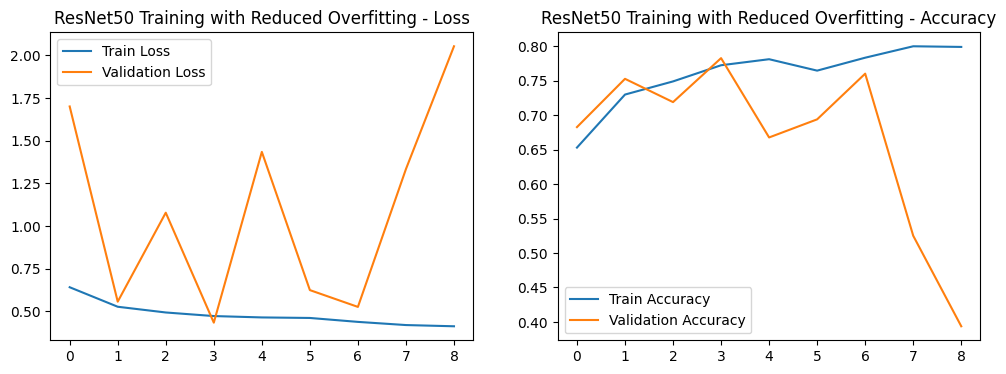

In [5]:
import os
import numpy as np
from scipy.io import loadmat
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Constants
DATA_PATH = "./AFLW2000"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 1e-4
LABELS = {0: "Away", 1: "Looking"}

# Define classification function
def classify_orientation(pose_para):
    yaw, pitch, roll = pose_para[:3]
    if (
        -0.6 <= yaw <= 0.6
        and -0.7 <= pitch <= 1.4
        and -0.3 <= roll <= 0.3
    ):
        return 1  # Looking
    return 0  # Away

# Load images and labels
def load_data_with_labels(data_path):
    images, labels = [], []
    for file_name in os.listdir(data_path):
        if file_name.endswith(".jpg"):
            img_path = os.path.join(data_path, file_name)
            mat_path = os.path.join(data_path, file_name.replace(".jpg", ".mat"))
            if not os.path.exists(mat_path):
                continue

            img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img_array)

            mat_data = loadmat(mat_path)
            pose_para = mat_data["Pose_Para"][0]
            label = classify_orientation(pose_para)
            labels.append(label)
    return np.array(images), np.array(labels)

# Preprocess data
def preprocess_data(images, labels):
    images = images / 255.0

    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True
    )
    augmented_images, augmented_labels = [], []
    for img, lbl in zip(images, labels):
        img = np.expand_dims(img, axis=0)
        for aug_img in datagen.flow(img, batch_size=1):
            augmented_images.append(aug_img[0])
            augmented_labels.append(lbl)
            break
    images = np.concatenate([images, np.array(augmented_images)])
    labels = np.concatenate([labels, np.array(augmented_labels)])

    x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
    return x_train, x_val, y_train, y_val

# Build ResNet50 model
def build_resnet50_model(input_shape, num_classes):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    
    # Allow fine-tuning of the last 50 layers
    for layer in base_model.layers[:-50]:
        layer.trainable = False
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation="relu")(x)  # Removed L2 regularization for simplicity
    x = Dropout(0.4)(x)  # Slightly reduced dropout
    predictions = Dense(num_classes, activation="softmax")(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

# Train the model
# Train the model
# Train the model
def train_model(model, train_data, val_data, epochs, class_weights):
    """
    Train the model with given training and validation data.
    Includes early stopping and model checkpointing.
    """
    x_train, y_train = train_data
    x_val, y_val = val_data

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        patience=5,          # Stop after 5 epochs of no improvement
        restore_best_weights=True,  # Restore the best weights after stopping
        verbose=1
    )
    model_checkpoint = ModelCheckpoint(
        "best_model.keras",  # Save the best model as .keras file (default format)
        save_best_only=True, # Only save if the model improves
        monitor='val_loss',  # Monitor validation loss
        mode='min',          # Look for the minimum validation loss
        verbose=1
    )

    # Train the model
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),  # Validation dataset
        epochs=epochs,                  # Number of epochs
        batch_size=BATCH_SIZE,          # Batch size
        class_weight=class_weights,     # Handle class imbalance
        callbacks=[early_stopping, model_checkpoint],  # Include callbacks
        verbose=1
    )

    return history


# Visualize training results
def plot_training_history(history, title="Training History"):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    plt.show()

# Main workflow
print("Loading data...")
images, labels = load_data_with_labels(DATA_PATH)

print("Displaying label distribution...")
unique, counts = np.unique(labels, return_counts=True)
print(f"Label distribution: {dict(zip(unique, counts))}")

print("Preprocessing data...")
x_train, x_val, y_train, y_val = preprocess_data(images, labels)

print("Computing class weights...")
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Building the model...")
cnn_model, base_model = build_resnet50_model((*IMG_SIZE, 3), num_classes=2)

print("Training the model...")
train_history = train_model(
    cnn_model,
    (x_train, y_train),
    (x_val, y_val),
    EPOCHS,
    class_weights_dict
)

print("Saving the final model...")
cnn_model.save("final_aflw2000_3d_orientation_model.h5", save_format="h5")
print("Model saved as 'final_aflw2000_3d_orientation_model.h5'.")

plot_training_history(train_history, title="ResNet50 Training with Reduced Overfitting")


Loading model...


Model loaded successfully.
Loading dataset for evaluation...
Selecting a subset for evaluation...
Evaluating model on a subset of the dataset...
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step

Classification Report:
              precision    recall  f1-score   support

        Away       0.75      0.67      0.71         9
     Towards       0.93      0.95      0.94        41

    accuracy                           0.90        50
   macro avg       0.84      0.81      0.82        50
weighted avg       0.90      0.90      0.90        50



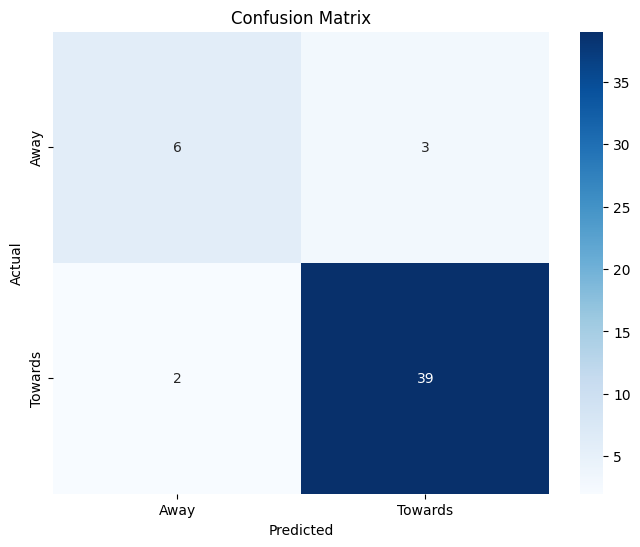

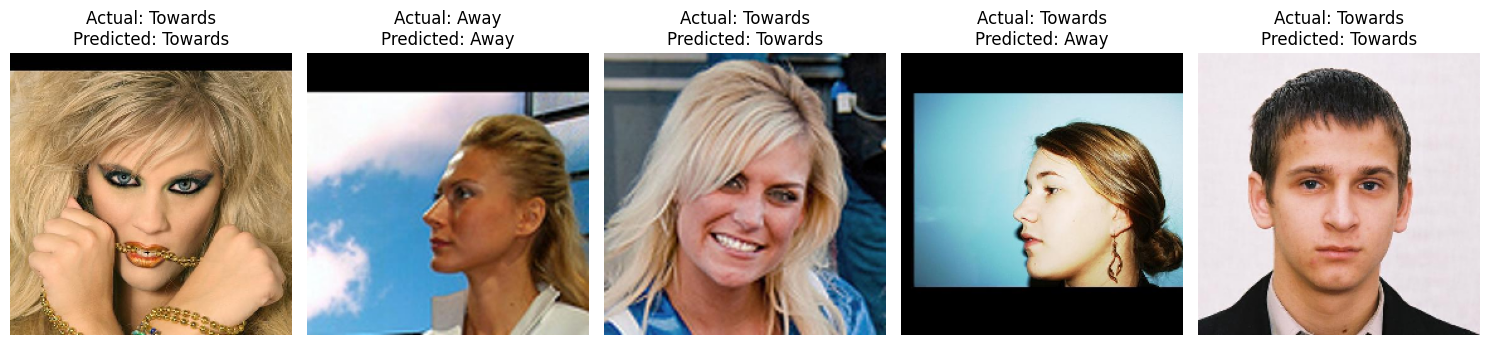

In [8]:
import tensorflow as tf
import numpy as np
import random
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Constants
LABELS = {0: "Away", 1: "Towards"}  # Updated for 2 classes
IMG_SIZE = (224, 224)
MODEL_PATH = "final_aflw2000_3d_orientation_model.h5"

# Load the fine-tuned model
print("Loading model...")
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded successfully.")

# Function to preprocess images
def preprocess_image(image):
    image = tf.image.resize(image, IMG_SIZE) / 255.0
    return image.numpy()

# Evaluate model on a subset of dataset images
def evaluate_model_with_subset(model, images, labels, num_samples=50):
    # Randomly select a subset of the data for evaluation
    indices = random.sample(range(len(images)), num_samples)
    x_test = np.array([preprocess_image(images[idx]) for idx in indices])
    y_test = labels[indices]

    # Predict and calculate metrics
    print("Evaluating model on a subset of the dataset...")
    y_pred_probs = model.predict(x_test, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=LABELS.values()))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS.values(), yticklabels=LABELS.values())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return x_test, y_test, y_pred

# Visualize random test samples
def visualize_predictions(model, x_test, y_test, y_pred, num_samples=5):
    indices = random.sample(range(len(x_test)), num_samples)
    plt.figure(figsize=(15, 10))

    for i, idx in enumerate(indices):
        img = x_test[idx]
        actual_label = LABELS[y_test[idx]]
        predicted_label = LABELS[y_pred[idx]]

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Load dataset images and labels
# Note: Ensure `images` and `labels` are loaded correctly based on your dataset structure
# Example: Use the same `load_data_with_labels()` from training to reload the data
print("Loading dataset for evaluation...")
images, labels = load_data_with_labels(DATA_PATH)

# Select subset and evaluate
print("Selecting a subset for evaluation...")
subset_size = 50  # Use a smaller subset for testing
x_test_subset = images[:subset_size]  # Adjust based on loaded dataset
y_test_subset = labels[:subset_size]  # Adjust based on loaded dataset

# Evaluate and visualize
x_test, y_test, y_pred = evaluate_model_with_subset(model, x_test_subset, y_test_subset)
visualize_predictions(model, x_test, y_test, y_pred, num_samples=5)
